In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/choose-tutors/submission_example.csv
/kaggle/input/choose-tutors/train.csv
/kaggle/input/choose-tutors/test.csv


In [63]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
test_df = pd.read_csv("/kaggle/input/choose-tutors/test.csv")

In [6]:
train_df = pd.read_csv("/kaggle/input/choose-tutors/train.csv")

#### Обзор обучающего датасета

In [7]:
train_df.head()

,Id,age,years_of_experience,lesson_price,qualification,physics,chemistry,biology,english,geography,history,mean_exam_points,choose
0,0,35.0,0.0,2150.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,74.0,0
1,1,52.0,2.0,1250.0,2.0,1.0,0.0,1.0,0.0,0.0,1.0,57.0,1
2,2,29.0,3.0,1750.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,66.0,0
3,3,33.0,3.0,1050.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,66.0,1
4,4,46.0,3.0,2250.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,73.0,0


In [8]:
train_df.describe().round()

,Id,age,years_of_experience,lesson_price,qualification,physics,chemistry,biology,english,geography,history,mean_exam_points,choose
count,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0
mean,5000.0,46.0,2.0,1702.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,64.0,0.0
std,2887.0,8.0,2.0,524.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,14.0,0.0
min,0.0,23.0,0.0,200.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,33.0,0.0
25%,2500.0,40.0,0.0,1300.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,55.0,0.0
50%,5000.0,46.0,2.0,1550.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,63.0,0.0
75%,7499.0,51.0,3.0,2150.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,74.0,0.0
max,9999.0,68.0,9.0,3950.0,4.0,1.0,1.0,1.0,1.0,1.0,1.0,100.0,1.0


In [9]:
print('Строк в трейне:', train_df.shape[0])
print('Строк в тесте', test_df.shape[0])

Строк в трейне: 10000
Строк в тесте 10000


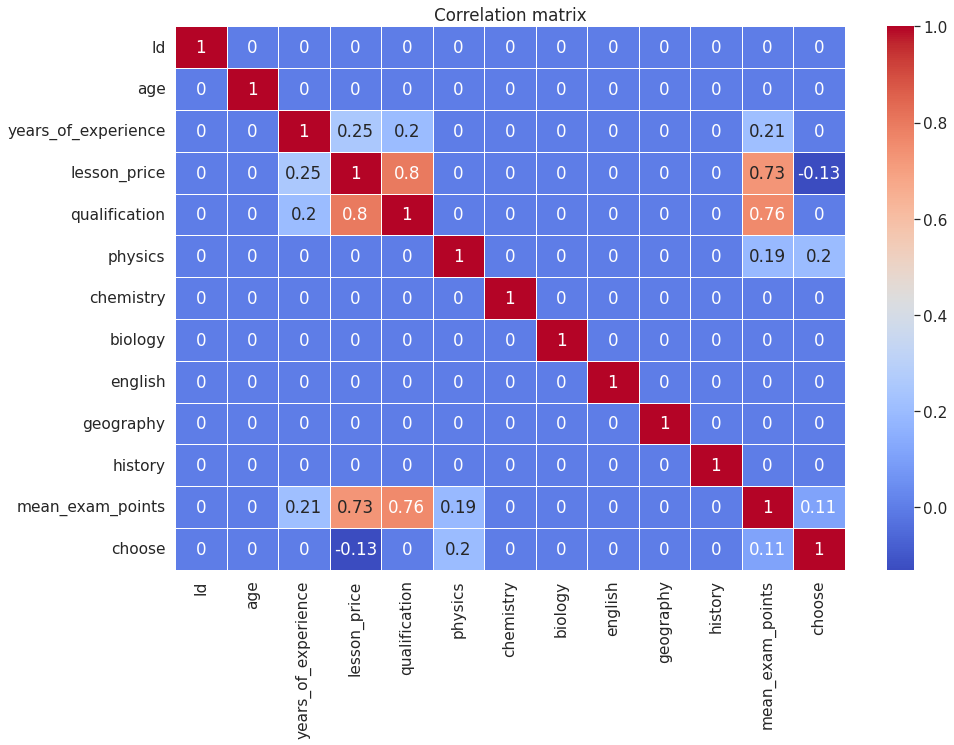

In [10]:
#Построим матрицу корреляций
plt.figure(figsize=(15, 10))

sns.set(font_scale=1.4)

corr_matrix = train_df.corr()
corr_matrix = np.round(corr_matrix, 2)
corr_matrix[np.abs(corr_matrix) < 0.1] = 0

sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='coolwarm')

plt.title('Correlation matrix')
plt.show()

In [11]:
train_df.dtypes

Id                       int64
age                    float64
years_of_experience    float64
lesson_price           float64
qualification          float64
physics                float64
chemistry              float64
biology                float64
english                float64
geography              float64
history                float64
mean_exam_points       float64
choose                   int64
dtype: object

In [12]:
TARGET_NAME = 'choose'
NUM_FEATURE_NAMES = ['age', 'years_of_experience', 'lesson_price', 'qualification', 'physics',
                     'chemistry', 'biology', 'english', 'geography', 'history', 'mean_exam_points']

Посмотрим есть ли пропуски

In [13]:
total = train_df.isnull().sum().sort_values(ascending=False)
percent = ((train_df.isnull().sum()/train_df.isnull().count())*100).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data

,Total,Percent
Id,0,0.0
age,0,0.0
years_of_experience,0,0.0
lesson_price,0,0.0
qualification,0,0.0
physics,0,0.0
chemistry,0,0.0
biology,0,0.0
english,0,0.0
geography,0,0.0


#### Пропуски отсутствуют

### Посмотрим на распределение признаков

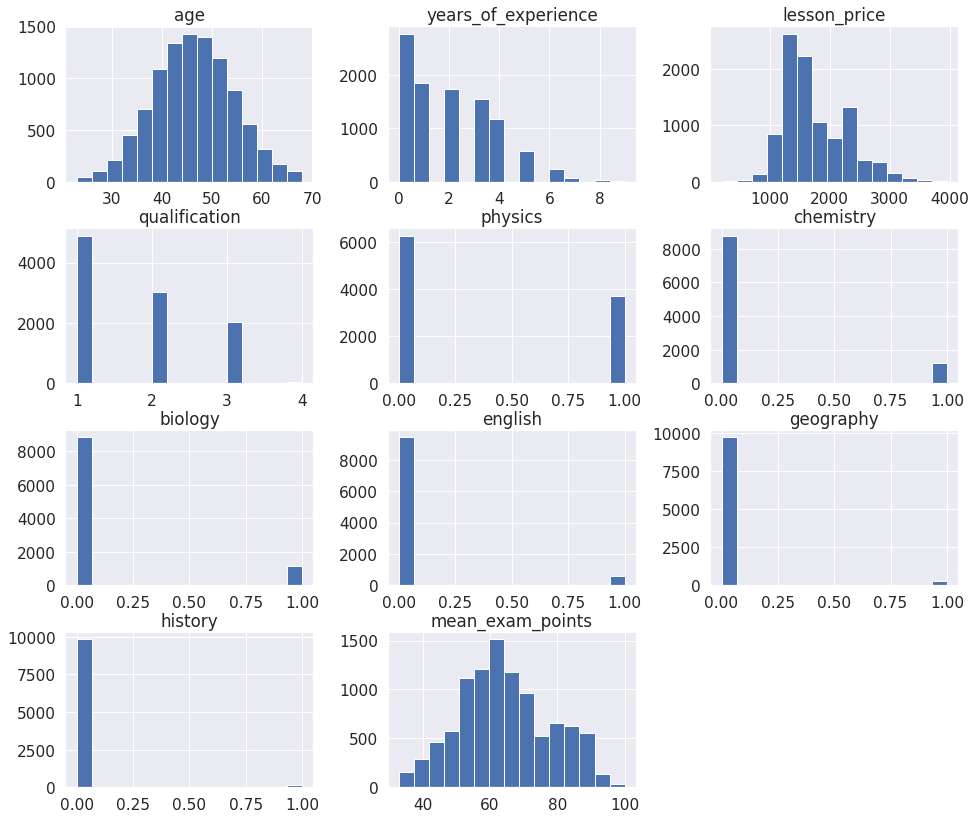

In [14]:
train_df[NUM_FEATURE_NAMES].hist(figsize =(16,14),bins = 15, grid = True)
plt.show()

#### Визуально можно сделать вывод что явных выбросов в числовых признаках нет

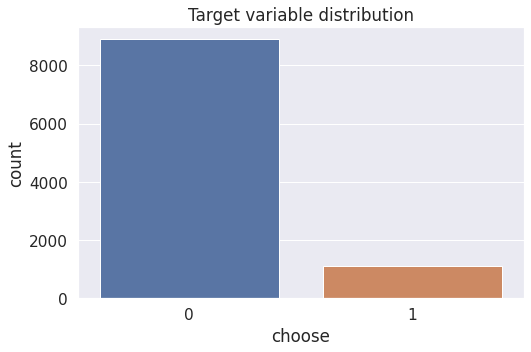

In [15]:
plt.figure(figsize=(8, 5))
sns.countplot(x=TARGET_NAME, data=train_df)
plt.title('Target variable distribution')
plt.show()

In [16]:
# Analogous to SMOTE balancing
def balance_df_by_target(df, target_name, balancing_type='oversampling'):
    target_counts = df[target_name].value_counts()

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()
    
    if balancing_type == 'oversampling':
        
        disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1

        for i in range(disbalance_coeff):
            sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
            df = df.append(sample, ignore_index=True)

        return df.sample(frac=1) 
    
    if balancing_type == 'undersampling':
        
        major_class_sample = df[df[target_name] == major_class_name].sample(target_counts[minor_class_name])
        minor_class_sample = df[df[target_name] == minor_class_name]
        
        df = pd.concat([major_class_sample, minor_class_sample], ignore_index=True)
        
        return df.sample(frac=1)

#### Будем использовать Ovarsampling

In [17]:
target = 'choose'
y = train_df[target]
X = train_df.drop(columns=['Id', 'choose'])
test_X = test_df.drop(columns='Id')

In [18]:
df_for_balancing = pd.concat([X, y], axis=1)
df_balanced = balance_df_by_target(df_for_balancing, target, balancing_type='oversampling')
    
df_balanced[target].value_counts()

0    8891
1    8872
Name: choose, dtype: int64

In [19]:
X = df_balanced.drop(columns=target)
y = df_balanced[target]

### Отмасштабируем получившиеся признаки методом стандартизации

In [20]:
def Standard(data):
    means = np.mean(data, axis=0)
    stds = np.std(data, axis=0)
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            data[i][j] = (data[i][j] - means[j])/stds[j]
    return data

In [21]:
X = X.values
y = y.values
test_X = test_X.values

In [22]:
Standard(X)
Standard(test_X)

array([[-1.73371969,  0.00807395,  1.90046712, ..., -0.17343093,
        -0.12382046,  1.90506341],
       [-1.36019396,  2.26652127,  0.19020064, ..., -0.17343093,
        -0.12382046,  0.50485588],
       [-0.23961676,  0.00807395, -0.94997702, ..., -0.17343093,
        -0.12382046, -1.41121759],
       ...,
       [-0.23961676,  0.00807395, -0.85496222, ..., -0.17343093,
        -0.12382046, -0.08470519],
       [ 0.63194329,  1.70190944, -1.33003624, ..., -0.17343093,
        -0.12382046, -0.01101005],
       [-0.36412533, -1.12114971, -0.37988819, ..., -0.17343093,
        -0.12382046, -1.70599812]])

### Перемещаем и разобьем датасет

In [23]:
# перемешивание датасета
np.random.seed(12)
shuffle_index = np.random.permutation(X.shape[0])
X_shuffled, y_shuffled = X[shuffle_index], y[shuffle_index]

# разбивка на обучающую и тестовую выборки
train_proportion = 0.7
train_test_cut = int(len(X) * train_proportion)

X_train, X_test, y_train, y_test = \
    X_shuffled[:train_test_cut], \
    X_shuffled[train_test_cut:], \
    y_shuffled[:train_test_cut], \
    y_shuffled[train_test_cut:]
    
print("Размер массива признаков обучающей выборки", X_train.shape)
print("Размер массива признаков тестовой выборки", X_test.shape)
print("Размер массива ответов для обучающей выборки", y_train.shape)
print("Размер массива ответов для тестовой выборки", y_test.shape)

Размер массива признаков обучающей выборки (12434, 11)
Размер массива признаков тестовой выборки (5329, 11)
Размер массива ответов для обучающей выборки (12434,)
Размер массива ответов для тестовой выборки (5329,)


In [24]:
#X_train_tr = X_train.transpose()
#y_train_tr = y_train.reshape(1, y_train.shape[0])
#X_test_tr = X_test.transpose()
#y_test_tr = y_test.reshape(1, y_test.shape[0])

#### Создадим класс нашей модели

In [26]:
class Logistic_regression:
    def __init__(self, n_iterations=1000, eta=0.05):
        self.n_iterations = 1000
        self.eta = eta

    @staticmethod
    def log_grad(w, c, X, target):
        m = X.shape[0]
        y = (2 * target - 1)
        score = np.dot(X, w.T).flatten()
        Z = -y / (m * (1 + np.exp(y * score)))
        grad = Z[np.newaxis, :].dot(X)
        return grad, np.sum(Z)

    @classmethod
    def optimize(cls, w, c, X, y, n_iterations, eta):
        for i in range(n_iterations):
            grad_w, grad_c = cls.log_grad(w, c, X, y)
            w = w - eta * grad_w
            c = c - eta * grad_c
        return w, c

    def fit(self, X, y):
        self.X = X
        self.y_true = y
        w0 = np.zeros((1, X.shape[1]))
        c0 = 0
        self.w, self.c = self.optimize(w0, c0, X, y, self.n_iterations, self.eta)

    def predict_proba(self, X):
        score = X.dot(self.w.T).flatten() + self.c
        self.score = score
        return 1 / (1 + np.exp(-score))

    def predict(self, X, thr=0.52): # Why threshold was set to this value? Below is a graph that explains this choice
        proba = self.predict_proba(X)
        y_predicted = np.zeros(proba.shape, dtype=bool)
        y_predicted[proba > thr] = 1
        y_predicted[proba <= thr] = 0
        self.y_predicted = y_predicted
        return y_predicted
    
    def confusion_matrix(self,X,y):
        y_pred = self.predict(X)
        predicted = np.where(y_pred == True, 1, 0)
        TP=np.sum(np.logical_and(predicted==1, y==1))
        FP=np.sum(np.logical_and(predicted==1, y==0))
        FN=np.sum(np.logical_and(predicted==0, y==1))
        TN=np.sum(np.logical_and(predicted==0, y==0))
        return np.array([[TP,FP],[FN, TN]])
         
        
    def make_auc_pr(self, X, Y):
        
        prob_x = self.predict_proba(X)
        targets = Y
        order = np.argsort(prob_x.flatten())
        targets = targets[order]
        num_pos=np.sum(targets)
        num_neg=len(targets)-num_pos

        TPR=np.concatenate([[0], np.cumsum(1-targets)/(num_neg)])
        FPR=np.concatenate([[0], np.cumsum(targets)/(num_pos)])
        
        plt.figure(figsize = (16, 7))
        plt.subplot(1,2,1)
        AUC_ROC = np.trapz(TPR, x = FPR, dx=0.1)
        plt.title('ROC curve')
        plt.ylim(0, 1.05)
        plt.xlabel('FPR')
        plt.ylabel('TPR')
        plt.grid()
        plt.legend(' ', title=f'AUC-ROC={AUC_ROC:.3f}')
        plt.plot(FPR, TPR)
        plt.subplot(1,2,2)
        precision=np.cumsum(1-targets)/(np.cumsum(1-targets)+np.cumsum(targets))
        recall = TPR
        AUC_PR = np.sum(precision*(TPR[1:]-TPR[:-1]))
        plt.title('PR curve')
        plt.ylim(0, 1.05)
        plt.xlabel('recall')
        plt.ylabel('presision')
        plt.grid()
        plt.legend(' ', title=f'AUC-PR={AUC_PR:.3f}')
        plt.plot(recall[1:], precision)

In [27]:
def log_loss(pred, y):
    return -np.sum(y*np.log(pred)+(1-y)*np.log(1-pred))/len(y)

#### Создадим модель и сделаем прогнозы

In [28]:
model = Logistic_regression()
model.fit(X_train, y_train)

y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)
y_test_pred_probs = model.predict_proba(X_test)

#### Оценка качества классификации

#### Accuracy это расчёт доли правильных ответов, имеет много недостатков

In [29]:
def my_accuracy(real, pred):
    all_res=len(real)
    trues=0
    for i in range(all_res):
        trues+=int(real[i]==pred[i])
    return trues/all_res

In [30]:
my_accuracy(y_train,y_train_pred)

0.7788322341965578

In [34]:
my_accuracy(y_test,y_test_pred)

0.7639331957215237

#### Матрица ошибок

Представление ответов в виде комбинации истинного ответа и ответа алгоритма

In [35]:
def my_confusion_matrix(real, pred):
    n_classes=len(np.unique(real))
    all_res=len(real)
    conf_matr=np.zeros((n_classes,n_classes), dtype='int')
    for i in range(all_res):
        conf_matr[int(real[i])][int(pred[i])] += 1
    return conf_matr  

In [36]:
my_confusion_matrix(y_train,y_train_pred)

array([[4931, 1257],
       [1493, 4753]])

In [37]:
my_confusion_matrix(y_test,y_test_pred)

array([[2119,  584],
       [ 674, 1952]])

#### Точность

In [38]:
def my_precision(real, pred):
    tn, fp, fn, tp = my_confusion_matrix(real, pred).ravel()
    return tp/(tp+fp)

In [39]:
my_precision(y_train,y_train_pred)

0.7908485856905159

In [40]:
my_precision(y_test,y_test_pred)

0.7697160883280757

#### Полнота

In [41]:
def my_recall(real, pred):
    tn, fp, fn, tp = my_confusion_matrix(real, pred).ravel()
    return tp/(tp+fn)

In [42]:
my_recall(y_train,y_train_pred)

0.760967018892091

In [43]:
my_recall(y_test,y_test_pred)

0.7433358720487433

#### F-мера,представляет собой среднее гармоническое между точностью и полнотой

In [46]:
def my_f1(real, pred, beta=1):
    return (1+beta**2)*my_precision(real, pred)*my_recall(y_train,y_train_pred)/(beta**2*my_precision(real, pred)+my_recall(y_train,y_train_pred))

In [47]:
my_f1(y_train,y_train_pred)

0.7756201044386424

In [48]:
def my_f1(real, pred, beta=1):
    return (1+beta**2)*my_precision(real, pred)*my_recall(y_test,y_test_pred)/(beta**2*my_precision(real, pred)+my_recall(y_test,y_test_pred))

In [49]:
my_f1(y_test,y_test_pred)

0.7562960092987214

#### Критерий AUC-ROC можно интерпретировать как вероятность того, что если выбрать случайные положительный и отрицательный объект выборки, положительный объект получит оценку принадлежности выше, чем отрицательный. AUC-ROC не очень устойчив к несбалансированным выборкам

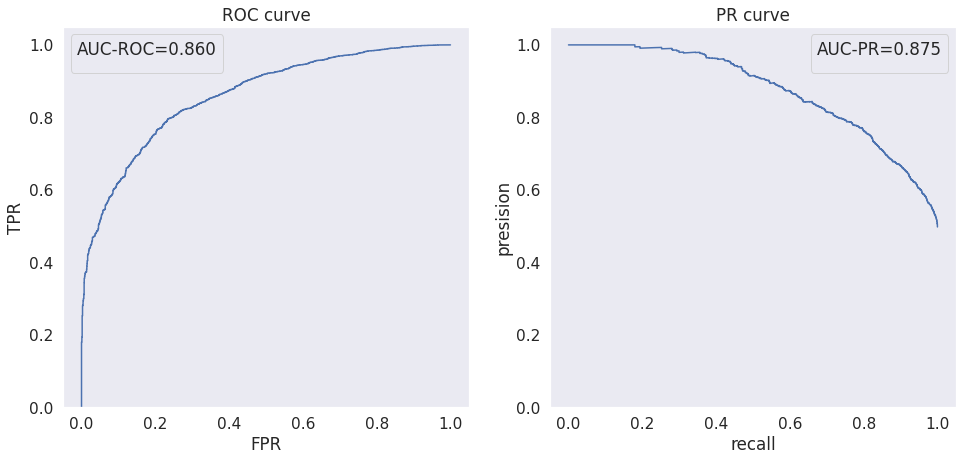

In [50]:
model.make_auc_pr(X_train, y_train)

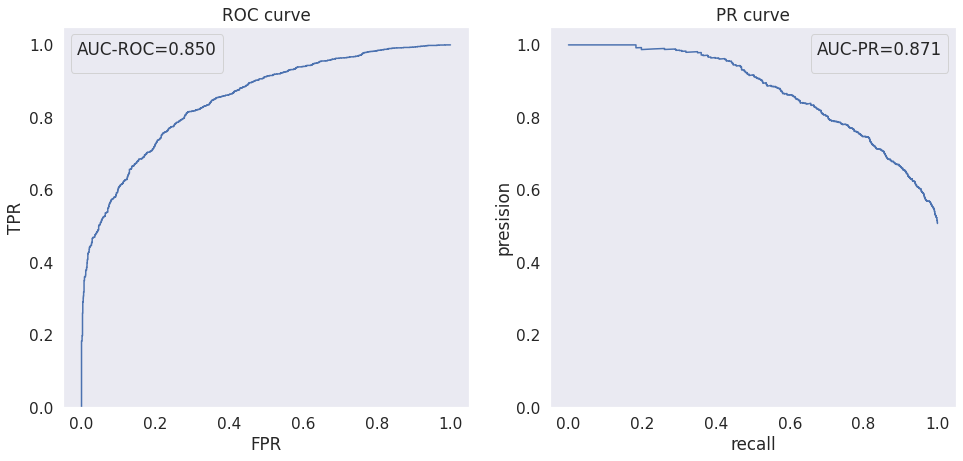

In [51]:
model.make_auc_pr(X_test, y_test)

In [60]:
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score

In [61]:
def show_proba_calibration_plots(y_predicted_probs, y_true_labels):

    preds_with_true_labels = np.array(list(zip(y_predicted_probs, y_true_labels)))

    thresholds = []
    precisions = []
    recalls = []
    f1_scores = []

    for threshold in np.linspace(0.1, 0.9, 9):
        thresholds.append(threshold)
        precisions.append(precision_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        recalls.append(recall_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        f1_scores.append(f1_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))

    scores_table = pd.DataFrame({'f1':f1_scores,
                                 'precision':precisions,
                                 'recall':recalls,
                                 'probability':thresholds}).sort_values('f1', ascending=False).round(3)
  
    figure = plt.figure(figsize = (15, 5))

    plt1 = figure.add_subplot(121)
    plt1.plot(thresholds, precisions, label='Precision', linewidth=4)
    plt1.plot(thresholds, recalls, label='Recall', linewidth=4)
    plt1.plot(thresholds, f1_scores, label='F1', linewidth=4)
    plt1.set_ylabel('Scores')
    plt1.set_xlabel('Probability threshold')
    plt1.set_title('Probabilities threshold calibration')
    plt1.legend(bbox_to_anchor=(0.25, 0.25))   
    plt1.table(cellText = scores_table.values,
               colLabels = scores_table.columns, 
               colLoc = 'center', cellLoc = 'center', loc = 'bottom', bbox = [0, -1.3, 1, 1])

    plt2 = figure.add_subplot(122)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 0][:, 0], 
              label='Another class', color='royalblue', alpha=1)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 1][:, 0], 
              label='Main class', color='darkcyan', alpha=0.8)
    plt2.set_ylabel('Number of examples')
    plt2.set_xlabel('Probabilities')
    plt2.set_title('Probability histogram')
    plt2.legend(bbox_to_anchor=(1, 1))

    plt.show()

#### Чтобы избавиться от такой проблемы, используется другой метод — кривая точности-полноты (PR-кривую). По оси  𝑥  откладывается полнота, по оси  𝑦  — точность, а точка на графике, аналогично ROC-кривой, будет соответствовать конкретному классификатору с некоторым значением порога.

Возьмём использованный нами для постройки ROC-кривой набор данных и аналогичным образом построим PR-кривую.

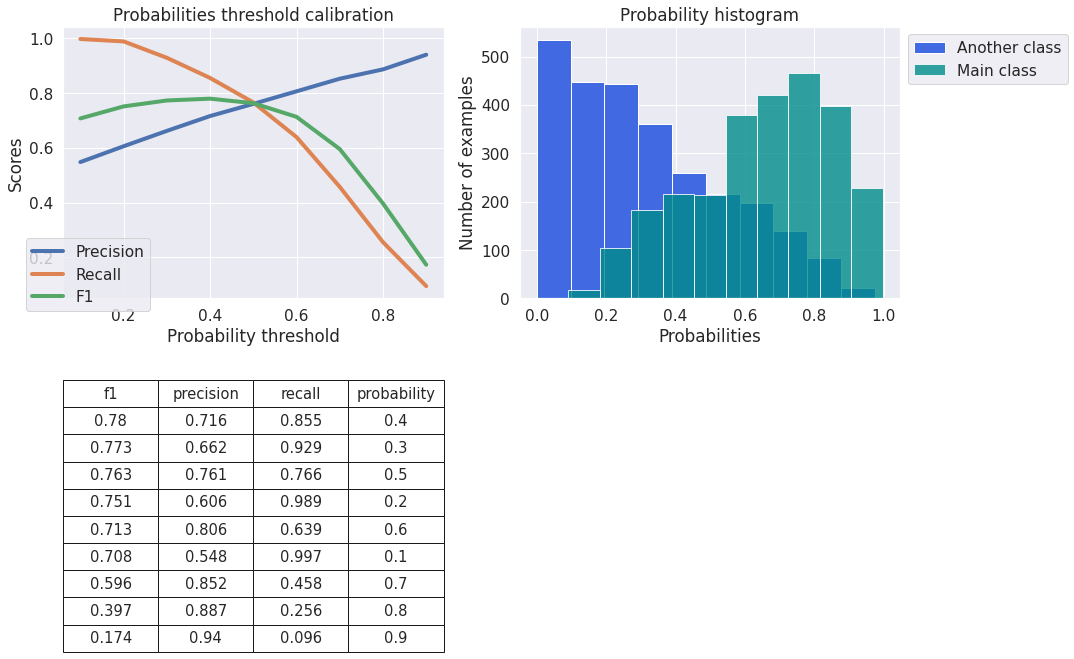

In [62]:
pred_proba = model.predict_proba(X_test)
show_proba_calibration_plots(pred_proba, y_test)

### Качество моодели получилось довольно неплохим, сохраняем модель

In [64]:
model.fit(X,y)

In [65]:
y_pred = model.predict_proba(test_X)

In [66]:
submis = pd.concat([test_df['Id'], pd.Series(y_pred)], axis = 1)
submis = submis.rename(columns = {0 : 'choose'})

In [67]:
submis.to_csv('LogRes_predict.csv', index=None)